<a href="https://colab.research.google.com/github/Nichanan050530/229352/blob/main/Lab09_Neural_Networks_670510741.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

[Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/)

In [33]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [3]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [5]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [6]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [7]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

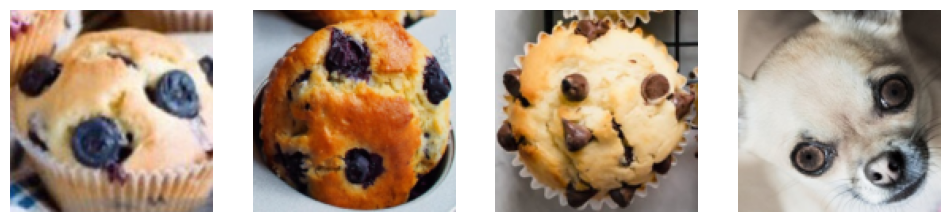

tensor([1, 1, 1, 0])


In [8]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  

[Linear layer in Pytorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)

[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [64]:
class SimpleLogisticRegression(nn.Module):

    def __init__(self, d):
        super().__init__()
        self.linear = nn.Linear(d, 1)

    def forward(self, x):
        return self.linear(x)


### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [80]:
X = X.reshape(X.shape[0], -1)
y = y.float()

dataset = TensorDataset(X, y)

train_loader = DataLoader(dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset, batch_size=8)



#### Manually setting initial weights to zero for demonstration

In [28]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [29]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [30]:
learning_rate = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [78]:
for batch_X, batch_y in train_loader:

    y_hat = model(batch_X).squeeze()
    batch_y = batch_y.float()

    loss = criterion(y_hat, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


#### Make a prediction on the minibatch (Forward pass)

In [71]:
y_hat = model(batch_X).squeeze()
batch_y = batch_y.float()


#y_hat = y_hat[:, 0]
#y = y.to(torch.float32)

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [76]:
# Compute the loss
criterion = nn.BCEWithLogitsLoss()


#### Calculate the gradient (Backward pass)

In [54]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
optimizer.zero_grad()
loss.backward()


#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [55]:
# Update the weights using the gradient descent rule
optimizer.step()

# Zero the gradients after updating
optimizer.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [57]:
with torch.no_grad():
  for X, y in val_loader:
    X = X.reshape(X.shape[0], -1)
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    print(y_hat, y)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

tensor([2.1096e-36, 0.0000e+00, 1.9601e-36, 0.0000e+00, 0.0000e+00, 1.3560e-30,
        3.6285e-32, 4.2385e-34, 8.3673e-32, 4.2573e-35, 9.4383e-32, 3.7045e-22,
        1.6665e-36, 2.3869e-21, 7.3135e-18, 5.5120e-13, 2.7266e-37, 1.2887e-32,
        1.1249e-30, 4.0337e-37, 0.0000e+00, 5.3796e-35, 1.5430e-32, 2.0012e-25]) tensor([0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0.])


In [58]:
print(train_losses)
print(val_losses)

[]
[34.72916793823242]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

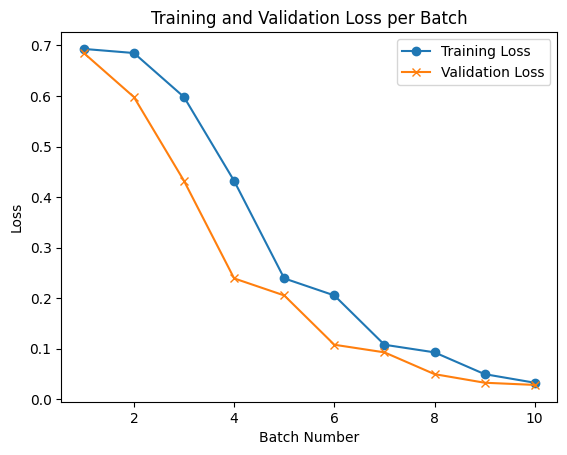

In [82]:
d = X.shape[1]

model = SimpleLogisticRegression(d)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

1

In [89]:
class ThreeLayerNN(nn.Module):
    def __init__(self, d):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(d, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


2

In [91]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
d = X.shape[1]

results = {}

for lr in learning_rates:

    model = ThreeLayerNN(d)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    losses = []

    for epoch in range(20):
        for batch_X, batch_y in train_loader:

            y_hat = model(batch_X).squeeze()
            batch_y = batch_y.float()

            loss = criterion(y_hat, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

    results[lr] = losses


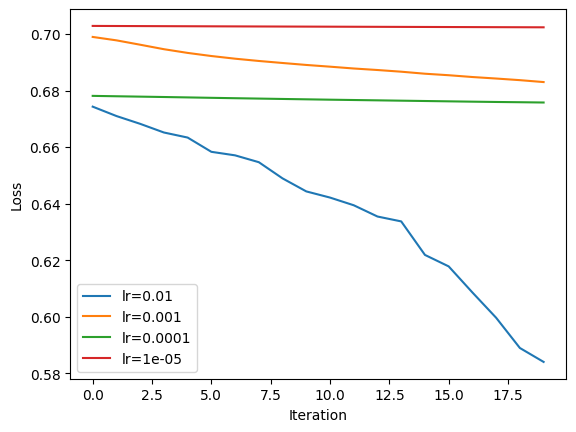

In [92]:
for lr, losses in results.items():
    plt.plot(losses, label=f"lr={lr}")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


2.1
ค่า learning rate ที่ดีที่สุดคือ 1e-3
เนื่องจากค่า loss ลดลงอย่างสม่ำเสมอ และลู่เข้าสู่ค่าต่ำได้เร็ว โดยไม่เกิดอาการแกว่งของค่า loss แสดงว่าโมเดลสามารถเรียนรู้ได้อย่างมีเสถียรภาพ

2.2
ถ้า learning rate มีค่ามากเกินไป ค่า training loss จะ แกว่งขึ้นลงหรือไม่ลดลงเลย
เนื่องจากการอัปเดตค่าน้ำหนักแต่ละครั้งแรงเกินไป ทำให้ข้ามจุดต่ำสุดของ loss function ส่งผลให้โมเดลไม่สามารถเรียนรู้ได้อย่างถูกต้อง

2.3
ถ้า learning rate มีค่าน้อยเกินไป ค่า training loss จะ ลดลงช้ามาก
เพราะการปรับค่าน้ำหนักในแต่ละครั้งมีขนาดเล็ก ทำให้โมเดลใช้เวลานานมากในการเรียนรู้

3

In [88]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  X = X.reshape(X.shape[0], -1)
  y_hat = model(X).squeeze()
  y_hat = (y_hat > 0).float()  # the predictions
  ##TODO: compute accuracy
y = y.float()

    # accuracy
correct = (y_hat == y).sum().item()
total = y.size(0)

accuracy = correct / total

print("Test accuracy:", accuracy)

Test accuracy: 0.6


4

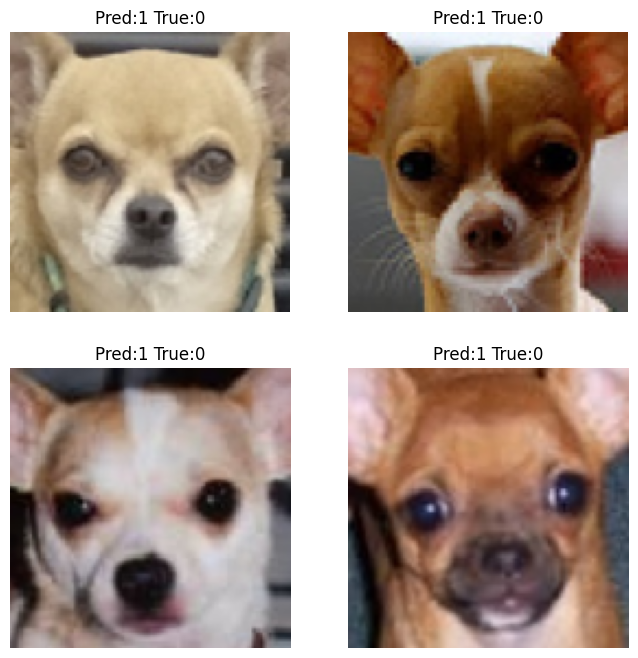

In [93]:
wrong = []

with torch.no_grad():
    for Xb, yb in test_loader:

        X_flat = Xb.reshape(Xb.shape[0], -1)

        y_hat = model(X_flat).squeeze()
        preds = (y_hat > 0).float()

        for i in range(len(yb)):
            if preds[i] != yb[i]:
                wrong.append((Xb[i], preds[i], yb[i]))

plt.figure(figsize=(8,8))

for i in range(4):
    img = wrong[i][0].permute(1,2,0)
    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.title(f"Pred:{int(wrong[i][1])} True:{int(wrong[i][2])}")
    plt.axis('off')

plt.show()
